### importer les bibliothe 

In [51]:
from pyspark.sql import SparkSession
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType, DoubleType, StringType
from pyspark.sql.functions import col, avg, count, max, min , sum
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

### Afficher le dataframe

In [2]:
#creer un session de spark
spark = SparkSession.builder.appName("Planéte").getOrCreate()

In [3]:
# Lecture du fichier CSV depuis HDFS
df_planets = spark.read.option("header", True).csv("hdfs://namenode:9000/user/hive/planets/planets_dataset.csv")

In [4]:
df_planets.show(5)

+------------+---------+--------+------------------+------------------+------------------+-----------------+--------------+-----------+
|        Name|Num_Moons|Minerals|           Gravity|    Sunlight_Hours|       Temperature|    Rotation_Time|Water_Presence|Colonisable|
+------------+---------+--------+------------------+------------------+------------------+-----------------+--------------+-----------+
|Planet_18329|        5|      59| 1.981602859469247|5.8168191458771705|28.381006239674264|56.76091939405808|             0|          0|
|Planet_28900|        8|     672|1.3881504830806715|14.715293728903166| 27.48564614824687| 51.0340563211323|             0|          0|
|Planet_56161|        3|     764|2.5308267251520093|22.902523479273974| 63.39082702246432|42.99324764351807|             1|          0|
|Planet_24869|        4|     881| 0.272197404132533|1.1764842767184982| 36.99844187739444|29.49224607367769|             1|          0|
|Planet_70594|        7|    1003|1.7310599130799

In [5]:
# Renommer les colonnes en français
df_planets = df_planets.withColumnRenamed("Name", "Nom") \
               .withColumnRenamed("Num_Moons", "Nombre_de_Lunes") \
               .withColumnRenamed("Minerals", "Mineraux") \
               .withColumnRenamed("Gravity", "Gravite") \
               .withColumnRenamed("Sunlight_Hours", "Heures_d_Ensoleillement") \
               .withColumnRenamed("Temperature", "Temperature") \
               .withColumnRenamed("Rotation_Time", "Temps_de_Rotation") \
               .withColumnRenamed("Water_Presence", "Presence_d_Eau") \
               .withColumnRenamed("Colonisable", "Colonisable")

# Affichage du DataFrame avec les noms de colonnes en français
df_planets.show(5)


+------------+---------------+--------+------------------+-----------------------+------------------+-----------------+--------------+-----------+
|         Nom|Nombre_de_Lunes|Mineraux|           Gravite|Heures_d_Ensoleillement|       Temperature|Temps_de_Rotation|Presence_d_Eau|Colonisable|
+------------+---------------+--------+------------------+-----------------------+------------------+-----------------+--------------+-----------+
|Planet_18329|              5|      59| 1.981602859469247|     5.8168191458771705|28.381006239674264|56.76091939405808|             0|          0|
|Planet_28900|              8|     672|1.3881504830806715|     14.715293728903166| 27.48564614824687| 51.0340563211323|             0|          0|
|Planet_56161|              3|     764|2.5308267251520093|     22.902523479273974| 63.39082702246432|42.99324764351807|             1|          0|
|Planet_24869|              4|     881| 0.272197404132533|     1.1764842767184982| 36.99844187739444|29.49224607367769

### Analyser le dataframe

In [6]:
# Vérifier les types après la conversion
df_planets.printSchema()

root
 |-- Nom: string (nullable = true)
 |-- Nombre_de_Lunes: string (nullable = true)
 |-- Mineraux: string (nullable = true)
 |-- Gravite: string (nullable = true)
 |-- Heures_d_Ensoleillement: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Temps_de_Rotation: string (nullable = true)
 |-- Presence_d_Eau: string (nullable = true)
 |-- Colonisable: string (nullable = true)



In [7]:
# Conversion des types de données après renommage
df_planets = df_planets \
    .withColumn("Nombre_de_Lunes", df_planets["Nombre_de_Lunes"].cast(IntegerType())) \
    .withColumn("Mineraux", df_planets["Mineraux"].cast(IntegerType())) \
    .withColumn("Gravite", df_planets["Gravite"].cast(DoubleType())) \
    .withColumn("Heures_d_Ensoleillement", df_planets["Heures_d_Ensoleillement"].cast(DoubleType())) \
    .withColumn("Temperature", df_planets["Temperature"].cast(DoubleType())) \
    .withColumn("Temps_de_Rotation", df_planets["Temps_de_Rotation"].cast(DoubleType())) \
    .withColumn("Presence_d_Eau", df_planets["Presence_d_Eau"].cast(IntegerType())) \
    .withColumn("Colonisable", df_planets["Colonisable"].cast(IntegerType()))

# Affichage du DataFrame avec les types de données convertis
df_planets.show(5)

+------------+---------------+--------+------------------+-----------------------+------------------+-----------------+--------------+-----------+
|         Nom|Nombre_de_Lunes|Mineraux|           Gravite|Heures_d_Ensoleillement|       Temperature|Temps_de_Rotation|Presence_d_Eau|Colonisable|
+------------+---------------+--------+------------------+-----------------------+------------------+-----------------+--------------+-----------+
|Planet_18329|              5|      59| 1.981602859469247|     5.8168191458771705|28.381006239674264|56.76091939405808|             0|          0|
|Planet_28900|              8|     672|1.3881504830806715|     14.715293728903166| 27.48564614824687| 51.0340563211323|             0|          0|
|Planet_56161|              3|     764|2.5308267251520093|     22.902523479273974| 63.39082702246432|42.99324764351807|             1|          0|
|Planet_24869|              4|     881| 0.272197404132533|     1.1764842767184982| 36.99844187739444|29.49224607367769

In [8]:
# Calculer le nombre de valeurs nulles par colonne
df_planets.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_planets.columns]).show()


+---+---------------+--------+-------+-----------------------+-----------+-----------------+--------------+-----------+
|Nom|Nombre_de_Lunes|Mineraux|Gravite|Heures_d_Ensoleillement|Temperature|Temps_de_Rotation|Presence_d_Eau|Colonisable|
+---+---------------+--------+-------+-----------------------+-----------+-----------------+--------------+-----------+
|  0|              0|       0|      0|                      0|          0|                0|             0|          0|
+---+---------------+--------+-------+-----------------------+-----------+-----------------+--------------+-----------+



In [9]:
df_planets = df_planets.dropna()

In [38]:
df_planets.dtypes

[('Nom', 'string'),
 ('Nombre_de_Lunes', 'int'),
 ('Mineraux', 'int'),
 ('Gravite', 'double'),
 ('Heures_d_Ensoleillement', 'double'),
 ('Temperature', 'double'),
 ('Temps_de_Rotation', 'double'),
 ('Presence_d_Eau', 'int'),
 ('Colonisable', 'int')]

### Préparation des données

In [10]:
## on converit le dataframe en pandas

df = df_planets.toPandas()

df.head()

,Nom,Nombre_de_Lunes,Mineraux,Gravite,Heures_d_Ensoleillement,Temperature,Temps_de_Rotation,Presence_d_Eau,Colonisable
0,Planet_18329,5,59,1.981603,5.816819,28.381006,56.760919,0,0
1,Planet_28900,8,672,1.388150,14.715294,27.485646,51.034056,0,0
2,Planet_56161,3,764,2.530827,22.902523,63.390827,42.993248,1,0
3,Planet_24869,4,881,0.272197,1.176484,36.998442,29.492246,1,0
4,Planet_70594,7,1003,1.731060,21.480324,23.266170,20.655958,0,0


### Diviser les données 

In [67]:
## Divise le dataframe
y  = df["Colonisable"]
X  = df.drop(["Colonisable", "Nom"] , axis = 1)


In [44]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajouter une dimension pour en faire un tableau 2D
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)


### normaliser les donées d'entrée

In [58]:

# Normalisation des caractéristiques
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Création de mon modèle

In [59]:
model = LinearRegression()

### Entraînement du modèle

In [68]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [48]:
### Prédiction de mon modèle

In [69]:
y_pred = model.predict(X_test_scaled)
y_pred

array([[-0.00015442],
       [ 0.10609668],
       [ 0.11180792],
       ...,
       [-0.01346072],
       [ 0.09448204],
       [ 0.00102208]])

In [70]:
R2 = model.score(X_test_scaled, y_pred)
R2

1.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


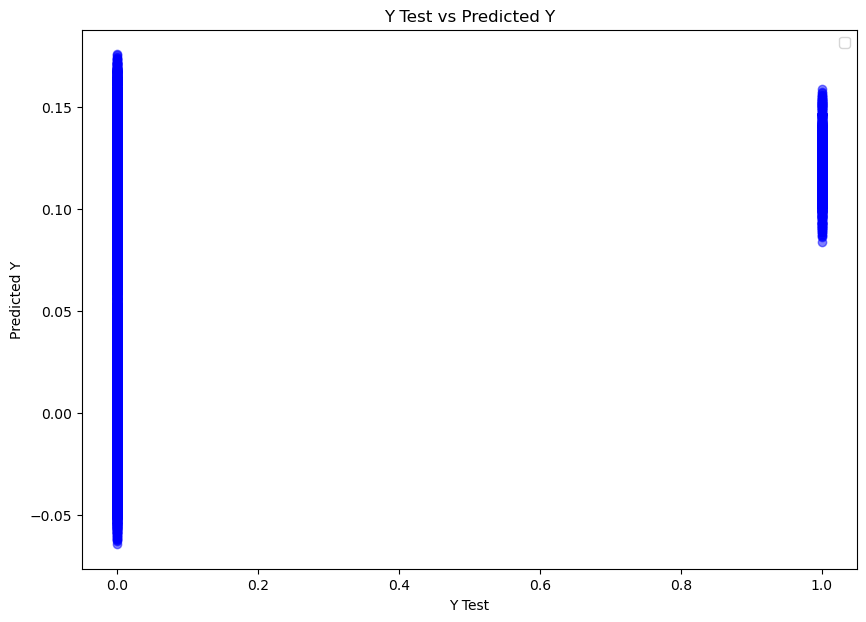

In [71]:
# Visualisation des résultats
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.title('Y Test vs Predicted Y')

plt.legend()

plt.show()
